<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/machine-learning-bookcamp/4_evaluation_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Evaluation Metrics

Churn is when customers stop using the services of a company. Thus, churn prediction
is about identifying customers who are likely to cancel their contracts soon.

If the company can do that, it can offer discounts on these services in an effort to
keep the users.

Imagine that we are working at a telecom company that offers phone and internet
services, and we have a problem: some of our customers are churning. They no longer
are using our services and are going to a different provider. 

We would like to prevent
that from happening, so we develop a system for identifying these customers and offer
them an incentive to stay. 

We want to target them with promotional messages and give
them a discount. We also would like to understand why the model thinks our customers
churn, and for that, we need to be able to interpret the model’s predictions.

In this notebook, we will discuss the ways of evaluating a binary classification model: 

* accuracy
* confusion table
* precision 
* recall
* ROC curve
* AUC

##Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [ ]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/blastchar/telco-customer-churn
kaggle datasets download -d blastchar/telco-customer-churn

unzip -qq telco-customer-churn.zip
rm -rf telco-customer-churn.zip

##Dataset

In [5]:
# let’s read our dataset
data_df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
len(data_df)

7043

In [6]:
# so, let's set the missing values to zero
data_df["TotalCharges"] = pd.to_numeric(data_df.TotalCharges, errors="coerce")
data_df["TotalCharges"] = data_df["TotalCharges"].fillna(0)

In [7]:
# Let’s make the column names uniform by lowercasing everything and replacing spaces with underscores
data_df.columns = data_df.columns.str.lower().str.replace(" ", "_")
string_columns = list(data_df.dtypes[data_df.dtypes == "object"].index)

for col in string_columns:
  data_df[col] = data_df[col].str.lower().str.replace(" ", "_")

In [8]:
# so, let’s convert the target variable to numbers
data_df.churn = (data_df.churn == "yes").astype(int)

In [9]:
# split such that 80% of the data goes to the train set and the remaining 20% goes to the test set.
df_train_full, df_test = train_test_split(data_df, test_size=0.2, random_state=1)

In [10]:
# let's split it one more time into train and validation
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

In [11]:
# Takes the column with the target variable, churn, and saves it outside the dataframe
y_train = df_train.churn.values
y_val = df_val.churn.values

In [12]:
# Deletes the churn columns
del df_train["churn"]
del df_val["churn"]

In [13]:
# let's create two lists for categorical and numerical variables
categorical_cols = [
  'gender', 'seniorcitizen', 'partner', 'dependents',
  'phoneservice', 'multiplelines', 'internetservice',
  'onlinesecurity', 'onlinebackup', 'deviceprotection',
  'techsupport', 'streamingtv', 'streamingmovies',
  'contract', 'paperlessbilling', 'paymentmethod'
]

numerical_cols = ['tenure', 'monthlycharges', 'totalcharges']

In [14]:
# convert dataframe to a list of dictionaries
train_dict = df_train[categorical_cols + numerical_cols].to_dict(orient="records")

In [15]:
# convert the list of dictionaries to matrix
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
x_train = dv.transform(train_dict)

##Classification model

In [16]:
model = LogisticRegression(solver="liblinear", random_state=1)
model.fit(x_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [17]:
# perform one-hot encoding in exactly the same way as during training
val_dict = df_val[categorical_cols + numerical_cols].to_dict(orient="records")
x_val = dv.transform(val_dict)

y_pred = model.predict_proba(x_val)[:, 1]

In [18]:
subset = ["contract", "tenure", "totalcharges"]
train_dict_small = df_train[subset].to_dict(orient="records")
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

x_small_train = dv_small.transform(train_dict_small)

In [19]:
# Let’s train the small model on this set of features
model_small = LogisticRegression(solver="liblinear", random_state=1)
model_small.fit(x_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [20]:
# let's validate this model
val_dict_small = df_val[subset].to_dict(orient="records")

x_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(x_small_val)[:, 1]

##Classification accuracy

This accuracy is the simplest way to evaluate a classifier: by counting the number of
cases in which our model turned out to be right.

Computing accuracy on the validation dataset is easy — we simply calculate the
fraction of correct predictions:

In [21]:
# Gets the predictions from the model
y_pred = model.predict_proba(x_val)[:, 1]

# Makes "hard" predictions
churn = y_pred >= .5

# Computes the accuracy
(churn == y_val).mean()

0.8016129032258065

Now we can loop over different thresholds and check which one gives the best accuracy:

In [22]:
# Creates an array with different thresholds
thresholds = np.linspace(0, 1, 21)
accuracies = []

for threshold in thresholds:
  churn = y_pred >= threshold
  acc = accuracy_score(y_val, churn)
  accuracies.append(acc)
  print(f"{threshold:.2f} >> {acc:.3f}")

0.00 >> 0.261
0.05 >> 0.501
0.10 >> 0.595
0.15 >> 0.640
0.20 >> 0.690
0.25 >> 0.730
0.30 >> 0.755
0.35 >> 0.767
0.40 >> 0.782
0.45 >> 0.795
0.50 >> 0.802
0.55 >> 0.790
0.60 >> 0.790
0.65 >> 0.788
0.70 >> 0.774
0.75 >> 0.752
0.80 >> 0.742
0.85 >> 0.739
0.90 >> 0.739
0.95 >> 0.739
1.00 >> 0.739


As we see, using the threshold of 0.5 gives us the best accuracy. 

In [23]:
max(accuracies)

0.8016129032258065

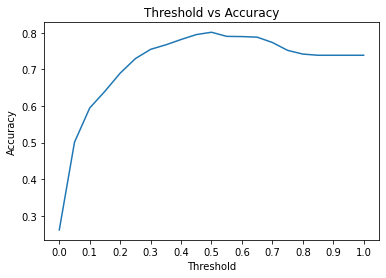

In [24]:
# Let's plot these values
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies)
plt.title("Threshold vs Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

plt.xticks(np.linspace(0, 1, 11))
plt.show()

So, the best threshold is `0.5`, and the best accuracy for this model that we can achieve is `80%`.

In [25]:
# Let’s also check small model's accuracy.
churn_small = y_pred_small >= .5

# Calculates the accuracy of the predictions
accuracy_score(y_val, churn_small)

0.7672043010752688

So, the large model is actually `4%` more accurate than the small model.


In our example, the dataset is imbalanced, and we don’t have many churned users.

So, the dummy model can always predict the majority class — “no churn.”

In [26]:
# Let’s create this baseline prediction
size_val = len(y_val)

baseline = np.repeat(False, size_val)

# check the accuracy of this baseline prediction
accuracy_score(baseline, y_val) 

0.7387096774193549

This means that the accuracy of the baseline
model is around `74%`.

As we see, the small model is only `2%` better than the naive baseline, and the large one is `6%` better.

Churn prediction is a complex problem, and maybe this improvement is great.
However, that’s not evident from the accuracy score alone. 

According to accuracy, our model is only slightly better than a dummy model that treats all the customers as nonchurning
and doesn’t attempt to keep any of them.

Thus, we need other metrics — other ways of measuring the quality of our model.

##Confusion matrix

In [27]:
t = 0.5

# Makes predictions at threshold 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

# Gets the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

# Calculates true positives (cases when we predicted churn correctly)
true_positive = (predict_churn & actual_churn).sum()
# Calculates false positives (cases when we predicted churn,but the customers didn't churn)
false_positive = (predict_churn & actual_no_churn).sum()

# Calculates false negatives (cases when we predicted no churn, but the customers churned)
false_negative = (predict_no_churn & actual_churn).sum()
# Calculates true negatives (cases when we predicted no churn correctly)
true_negative = (predict_no_churn & actual_no_churn).sum()

In [28]:
# Now we just need to put all these values together
confusion_table = np.array(
  #  predict neg    pos
  [
    [true_negative, false_positive], # actual neg
    [false_negative, true_positive]  # actual pos
  ]
)

confusion_table

array([[1202,  172],
       [ 197,  289]])

In [29]:
# Confused!! so we can turn them into fractions by dividing each value by the total number of items
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

We actually see that the performance of the model
is not great: it makes quite a few errors when trying to identify users that will churn.

We can repeat the same process for the small model.

In [30]:
# select the first customer's probability of staying
t = 0.5

# Makes predictions at threshold 0.5
predict_churn = (y_pred_small >= t)
predict_no_churn = (y_pred_small < t)

# Gets the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

# Calculates true positives (cases when we predicted churn correctly)
true_positive = (predict_churn & actual_churn).sum()
# Calculates false positives (cases when we predicted churn,but the customers didn't churn)
false_positive = (predict_churn & actual_no_churn).sum()

# Calculates false negatives (cases when we predicted no churn, but the customers churned)
false_negative = (predict_no_churn & actual_churn).sum()
# Calculates true negatives (cases when we predicted no churn correctly)
true_negative = (predict_no_churn & actual_no_churn).sum()

In [31]:
# Now we just need to put all these values together
confusion_table = np.array(
  #  predict neg    pos
  [
    [true_negative, false_positive], # actual neg
    [false_negative, true_positive]  # actual pos
  ]
)

confusion_table

array([[1189,  185],
       [ 248,  238]])

In [32]:
# Confused!! so we can turn them into fractions by dividing each value by the total number of items
confusion_table / confusion_table.sum()

array([[0.63924731, 0.09946237],
       [0.13333333, 0.12795699]])

The values from the confusion table serve as the basis for many other evaluation
metrics.

##Precision and recall

Both precision and recall are calculated from the values of the confusion table.
They both help us understand the quality of the model in cases of class imbalance.

The precision of a model tells us how many of the pos
itive
predictions turned out to be correct.

Recall is the fraction of correctly classified positive examples among all positive examples.

In our case, to calculate recall we first look at all the customers who churned and
see how many of them we managed to identify correctly.

Precision helps us understand how many people received a promotional message
by mistake.

Recall helps us understand how many of the churning customers we failed to find.

In [33]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

precision, recall

(0.5626477541371159, 0.4897119341563786)

##ROC and AUC

We need two metrics for ROC curves: TPR and FPR, or true positive rate and false
positive rate.

Like precision and recall, these values are based on the confusion matrix

Binary classification models, such as logistic regression, typically output a probability —
a score between zero and one. 

To make actual predictions, we binarize the output by
setting some threshold to get only True and False values.

Instead of evaluating the model at one particular threshold, we can do it for a
range of them.

In [34]:
# Computing the confusion table for different thresholds
scores = []

thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
  # Computes the confusion table for predictions at each threshold
  tp = ((y_pred >= threshold) & (y_val == 1)).sum()
  fp = ((y_pred >= threshold) & (y_val == 0)).sum()
  fn = ((y_pred < threshold) & (y_val == 1)).sum()
  tn = ((y_pred < threshold) & (y_val == 0)).sum()
  scores.append((threshold, tp, fp, fn, tn))

It’s not easy to deal with a list of tuples, so let’s convert it to a Pandas dataframe.

In [35]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ["threshold", "tp", "fp", "fn", "tn"]

# selects every 10th record of the dataframe
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


Now we can compute the TPR and FPR scores.

In [36]:
df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


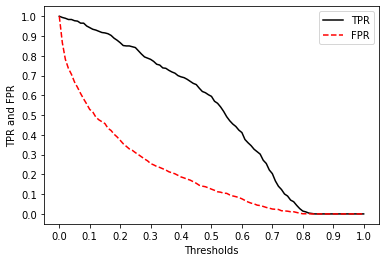

In [37]:
# Let’s plot them
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color="k", linestyle="solid", label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, color="r", linestyle="dashed", label="FPR")
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel("Thresholds")
plt.ylabel("TPR and FPR")

plt.show()

Ideally, FPR should go down very quickly. A small FPR indicates that the model
makes very few mistakes predicting negative examples (false positives).

On the other hand, TPR should go down slowly, ideally staying near 100% all the time:
that will mean that the model predicts true positives well.

##Baseline model

A random model outputs a random score between 0 and 1, regardless of the input. 

It’s easy to implement — we simply generate an array with uniform random numbers:

In [38]:
np.random.seed(1)

y_rand = np.random.uniform(0, 1, size=len(y_val))

Now we can simply pretend that `y_rand` contains the predictions of our "model".

Let’s calculate FPR and TPR for our random model.

In [39]:
# Function for calculating TPR and FPR at different thresholds
def tpr_fpr_dataframe(y_val, y_pred):
  scores = []
  thresholds = np.linspace(0, 1, 101)

  # Calculates the confusion table for different thresholds
  for threshold in thresholds:
    tp = ((y_pred >= threshold) & (y_val == 1)).sum()
    fp = ((y_pred >= threshold) & (y_val == 0)).sum()
    fn = ((y_pred < threshold) & (y_val == 1)).sum()
    tn = ((y_pred < threshold) & (y_val == 0)).sum()
    scores.append((threshold, tp, fp, fn, tn))

  # Converts the confusion table numbers to a dataframe
  df_scores = pd.DataFrame(scores)
  df_scores.columns = ["threshold", "tp", "fp", "fn", "tn"]

  # Calculates TPR and FPR using the confusion table numbers
  df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
  df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

  return df_scores

In [40]:
# calculate the TPR and FPR for the random model
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


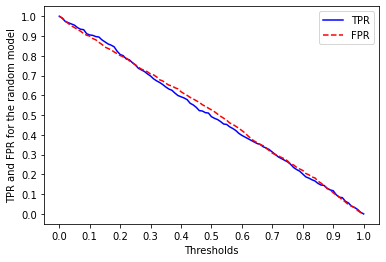

In [42]:
# Let’s plot them
plt.figure(figsize=(6, 4))

plt.plot(df_rand.threshold, df_rand.tpr, color="b", linestyle="solid", label="TPR")
plt.plot(df_rand.threshold, df_rand.fpr, color="r", linestyle="dashed", label="FPR")
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel("Thresholds")
plt.ylabel("TPR and FPR for the random model")

plt.show()

##Ideal model